In [299]:
import os

import lucem_illud
import openai
import pandas as pd
import sklearn
from IPython.display import Image
from openai import OpenAI

# Constants, Utility Functions, and Data Importing

In [264]:
# Constants and Clients
GPT_MODEL = "gpt-3.5-turbo"
MAX_CHAR_LEN = 5000000
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

openai_client = OpenAI(api_key=OPENAI_API_KEY)
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=0.5, max_features=1000, min_df=3, stop_words="english", norm="l2"
)

In [265]:
# Utility Functions


def generate_text_with_style(prompt: str):
    """
    This function takes a piece of text and uses OpenAI's GPT-4 to rewrite it in a specified style.
    """
    openai.api_key = OPENAI_API_KEY

    try:
        response = openai_client.completions.create(
            model=GPT_MODEL + "-instruct",
            prompt=prompt,
            temperature=0.6,
            max_tokens=300,
        )
        return response.choices[0].text.strip()
    except Exception as e:
        return str(e)


def drop_missing(word_list, vocab):
    return [w for w in word_list if w in vocab or not w]

In [266]:
# Data Importing
# Data is sourced from a personal project of mine you can find here:
# https://ucpd-incident-reporter-7cfdc3369124.herokuapp.com/
ucpd_feather_path = "data/fully_tokenized_ucpd_incidents.feather"
if os.path.isfile(ucpd_feather_path):
    ucpd_reports = pd.read_feather(ucpd_feather_path)
else:
    # WARNING: This step takes about 120 minutes, so don't run it unless you need to.
    ucpd_reports = pd.read_csv("data/incident_dump.csv")
    ucpd_reports["tokenized_text"] = ucpd_reports["comments"].apply(
        lucem_illud.word_tokenize
    )
    ucpd_reports["normalized_text"] = ucpd_reports["tokenized_text"].apply(
        lucem_illud.normalizeTokens
    )
    ucpd_tfidf_vectors = tfidf_vectorizer.fit_transform(ucpd_reports["comments"])
    ucpd_reports["reduced_tokens"] = ucpd_reports["normalized_text"].apply(
        lambda x: drop_missing(x, tfidf_vectorizer.vocabulary_.keys())
    )
    ucpd_reports.to_feather(ucpd_feather_path)
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text,reduced_tokens
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,...","[person, comer, hospital, cfd, ems, evaluation]"
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str...","[catalytic, converter, toyota, park, street]"
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended...","[debit, credit, card, wallet, unattended, unse..."
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat...","[boyfriend, girlfriend, campus, private, apart..."
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me...","[suspect, enter, campus, store, merchandise, p..."
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,...","[person, social, security, card, street, ucpd]"
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,...","[window, van, park, street, campus, refer, cpd]"
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp...","[unknown, force, entry, victim, campus, apartm..."
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp...","[unknown, person, attempt, enter, victim, camp..."
9,Victim walking in the cr

## <font color="red">*Exercise 1*</font>

<font color="red">As this week's challenging questions asks, we'd like you to 
think how LLM can help your final project.  Try to use the OpenAI API to analyze 
a small-sized dataset (Remember to monitor API use on your OpenAI account!). The 
data could a sample from the dataset you prepare for the final project or some 
others. If it's going be a conventional task like classification, compare and 
see how it could beat(or being defeated) by other algorithms you've learned from 
previous weeks. If it's a special task that you cannot find a learned algorithm 
to compare with, evaluate its performance on your own and try if you can improve 
by changing hyperparameters(see [here](https://platform.openai.com/docs/api-reference/chat/create)), the prompt, etc.

In [267]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['A', 'person', 'was', 'transported', 'to', 'Comer', 'Hospital', 'by', 'CFD', 'EMS', 'for', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', 'from', 'a', '2015', 'toyota', 'parked', 'on', 'the', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards'

In [268]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by using all industry standard token normalization functions. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['a', 'person', 'was', 'transported', 'to', 'comer', 'hospital', 'by', 'cfd', 'ems', 'for', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic' 'converter' 'taken' 'from' 'a' '2015' 'toyota' 'parked' 'on'
 'the' 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 

In [269]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, and converting all tokens to lower case. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'comer', 'hospital', 'cfd', 'ems', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

In [270]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, converting all tokens to lower case, and reducing the tokens using Tf-IDF. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: person transported comer hospital cfd ems evaluation
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' 'purse' 'Unauthorized' 

**Discussion:** Varying the prompts gave promising results. The examples also show
that it is more beneficial to be explicit about your requests than to infer what
should be done.

## <font color="red">*Exercise 2*</font>

<font color="red">Fine-tune an LLM. You can either use the model (llama-2-7b) in 
the example code or find another open-source LLM. You may use datasets provided 
by HuggingFace or a dataset you collect from somewhere else (for your final project). 
If the task happens to be the same as in exercise 1, You can choose to compare the 
performance between the OpenAI LLM and your fine-tuned LLM. You can also choose to 
compare the performance between the vanilla and the fine-tuned LLM.

I am going to opt for tuning the OpenAI LLM by changing its hyperparameters.

In [271]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.2,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, removing stop words,, converting all tokens to lower case, and reducing the tokens using Tf-IDF. After normalizing the tokens, return ONLY the tokens in a python formatted list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'Comer', 'Hospital', 'CFD', 'EMS', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

In [272]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.5,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, removing stop words,, converting all tokens to lower case, and reducing the tokens using Tf-IDF. After normalizing the tokens, return ONLY the tokens in a python formatted list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'Comer', 'Hospital', 'CFD', 'EMS', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

In [317]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.8,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, removing stop words,, converting all tokens to lower case, and reducing the tokens using Tf-IDF. After normalizing the tokens, return ONLY the tokens in a python formatted list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'comer', 'hospital', 'cfd', 'ems', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

In [273]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.8,
        n=5,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, removing stop words, converting all tokens to lower case, and reducing the tokens using Tf-IDF.  After normalizing the tokens, return ONLY the tokens in a python formatted list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'Comer', 'Hospital', 'CFD', 'EMS', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

In [274]:
for i in range(3):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.8,
        n=10,
        messages=[
            {
                "role": "user",
                "content": f"Normalize this token list by removing stop words, lemmatizing the appropriate words, removing punctuation, removing stop words, converting all tokens to lower case, and reducing the tokens using Tf-IDF.  After normalizing the tokens, return ONLY the tokens in a python formatted list. Message:\n\n {ucpd_reports['tokenized_text'].iloc[i]}",
            }
        ],
    )

    print(f"Original string: {ucpd_reports['comments'].iloc[i]}")
    print(f"Non-normalized tokens: {ucpd_reports['tokenized_text'].iloc[i]}")
    print(f"Normalized tokens: {ucpd_reports['normalized_text'].iloc[i]}")
    print(f"OpenAI response: {resp.choices[0].message.content}")
    if i != 2:
        print("----")

Original string: A person was transported to Comer Hospital by CFD EMS for evaluation
Non-normalized tokens: ['A' 'person' 'was' 'transported' 'to' 'Comer' 'Hospital' 'by' 'CFD' 'EMS'
 'for' 'evaluation']
Normalized tokens: ['person' 'transport' 'comer' 'hospital' 'cfd' 'ems' 'evaluation']
OpenAI response: ['person', 'transported', 'Comer', 'Hospital', 'CFD', 'EMS', 'evaluation']
----
Original string: Catalytic converter taken from a 2015 Toyota parked on the street
Non-normalized tokens: ['Catalytic' 'converter' 'taken' 'from' 'a' '2015' 'Toyota' 'parked' 'on'
 'the' 'street']
Normalized tokens: ['catalytic' 'converter' 'take' 'toyota' 'park' 'street']
OpenAI response: ['catalytic', 'converter', 'taken', '2015', 'toyota', 'parked', 'street']
----
Original string: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
Non-normalized tokens: ['Debit' 'and' 'credit' 'cards' 'taken' 'from' 'wallet' 'in' 'unattended'
 'unsecured' '

**Discussion:** The results indicate to me that temperature is likely not the best
hyperparameter to modify to improve results. Given the relatively small size of the
task, I think we were not able to see the benefits on multiple executions, as per
the last two trials. If the task were more complex or larger, perhaps that would
have not been the case.

## <font color="red">*Exercise 3*</font>
<font color="red">Use LLM to generate some data and compare the differences between model-generated 
data and actual data. This exercise should not be a repetition of exercise 1. You should 
focus more on analyzing language nuances, qualitatively or quantitatively. You should also 
notice how the choice of LLM has possibly impacted the language it uses.

In [324]:
resp_q0 = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0.1,
    n=10,
    messages=[
        {
            "role": "user",
            "content": "In Hyde Park, Chicago, what is the most often type of criminal incident reported to the University of Chicago Police Department? Please respond back with the top 3 most frequently cited categories.",
        }
    ],
)

print(resp_q0.choices[0].message.content)

The University of Chicago Police Department (UCPD) does not publicly disclose specific crime statistics or incident reports for Hyde Park, Chicago. However, based on general crime trends in urban areas, the top three most frequently cited categories of criminal incidents reported to police departments typically include:

1. Theft/Larceny: This category includes various forms of theft, such as pickpocketing, shoplifting, theft from vehicles, and stolen bicycles.

2. Burglary: Burglary involves the unlawful entry into a building or structure with the intent to commit theft or another felony. This category may include residential burglaries, commercial burglaries, or burglaries of other types of structures.

3. Assault: Assault refers to incidents involving physical harm or the threat of physical harm to another person. This category may include simple assaults, aggravated assaults, or domestic violence incidents.

Please note that these are general categories and may not reflect the spec

In [325]:
resp_q1 = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0.5,
    n=10,
    messages=[
        {
            "role": "user",
            "content": "In Hyde Park, Chicago, what is the most often type of criminal incident reported to the University of Chicago Police Department? Please respond back with the top 3 most frequently cited categories.",
        }
    ],
)

print(resp_q1.choices[0].message.content)

The University of Chicago Police Department (UCPD) does not publicly release detailed crime statistics specific to Hyde Park, Chicago. However, based on available information, the top three most frequently cited categories of criminal incidents reported to the UCPD in Hyde Park are generally:

1. Theft/Larceny: This category typically includes incidents involving stolen personal property, such as theft from vehicles, theft of bicycles, shoplifting, and other similar offenses.

2. Property Damage/Vandalism: This category involves incidents of intentional damage to property, including acts of vandalism, graffiti, and destruction of university or private property.

3. Assault/Battery: This category includes incidents involving physical altercations, fights, or assaults on individuals, often resulting in injuries.

Please note that these categories are based on general knowledge and may not represent the most up-to-date or comprehensive information. It is always advisable to consult offici

In [326]:
resp_q2 = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0.9,
    n=10,
    messages=[
        {
            "role": "user",
            "content": "In Hyde Park, Chicago, what is the most often type of criminal incident reported to the University of Chicago Police Department? Please respond back with the top 3 most frequently cited categories.",
        }
    ],
)

print(resp_q2.choices[0].message.content)

According to the University of Chicago Police Department, the top three most frequently cited categories of criminal incidents reported in Hyde Park, Chicago are:

1. Theft - This includes incidents of property theft, such as stolen vehicles, theft from buildings, and theft of personal belongings.

2. Burglary - This refers to unlawful entry into a structure, including homes, apartments, or non-residential buildings, with the intent to commit theft or another criminal act.

3. Robbery - This involves the use of force, threat, or intimidation to steal property directly from a person. It typically involves a confrontation between the offender and the victim.

Please note that these statistics are subject to change over time, and it is always recommended to refer to the University of Chicago Police Department's official records for the most accurate and up-to-date information on crime statistics.


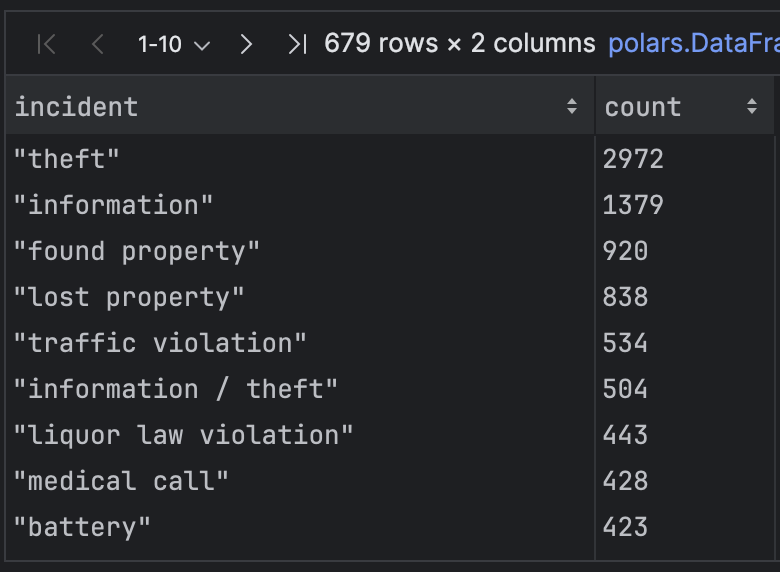

In [323]:
Image("misc/top_10_incidents.png")

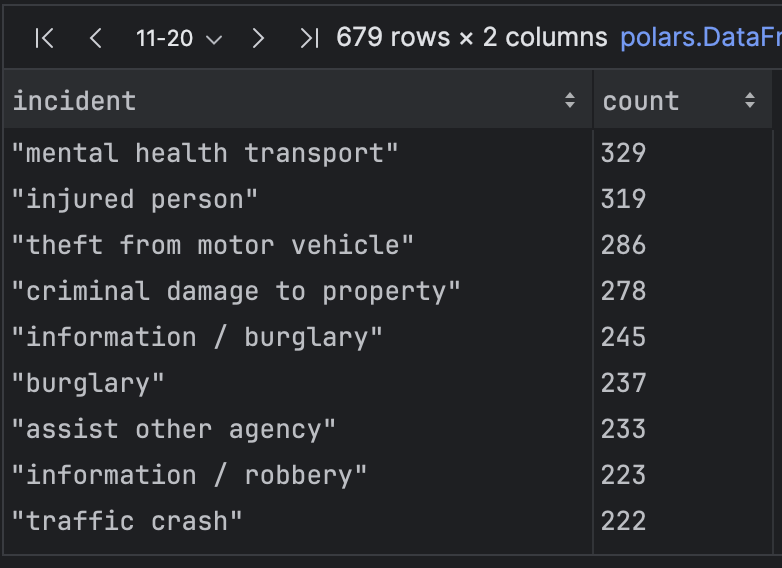

In [302]:
Image("misc/top_20_incidents.png")

**Discussion:** The guesses by the LLM wer fairly accurate in all the trials,
and unlike Exercise 2, I believe this question was complex enough to benefit
from the use of the `n` parameter.

## <font color="red">*Exercise 4*</font>

<font color="red">Compare how LLMs change their performance with different 
shots on your task. If the evaluation criterion is quantifiable, such as 
classification with ground truth labels, plot and show how accuracy changes. 
If the evaluation criterion cannot be easily quantified, such as the clarity 
of explaining a concept, use your imagination to do some comparison (for 
example, you can ask another LLM to rate its peer :)) If you find close-sourced 
LLM APIs pricey and are unsatisfied with responses from small-sized open-sourced 
LLMs, you can try large-sized LLMs (such as 70B version Llama-2) with Petals 
(see [here](https://colab.research.google.com/drive/1uCphNY7gfAUkdDrTx21dZZwCOUDCMPw8?usp=sharing) and [here](https://colab.research.google.com/drive/1Ervk6HPNS6AYVr3xVdQnY5a-TjjmLCdQ)).

In [313]:
for i in range(15):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.1,
        messages=[
            {
                "role": "user",
                "content": f"Using categories no more than 7 words, categorize this incident that was reported the the University of Chicago Police Department into a discrete category. Please return only the category name and a float stating how certain you are with that categorization. Message:\n\n {ucpd_reports['comments'].iloc[i]}",
            }
        ],
    )

    print(f"Original category: {ucpd_reports['incident'].iloc[i]}")
    print(f"Incident description: {ucpd_reports['comments'].iloc[i]}")
    print(f"OpenAI category: {resp.choices[0].message.content}")
    if i != 14:
        print("----")

Original category: Mental Health Transport
Incident description: A person was transported to Comer Hospital by CFD EMS for evaluation
OpenAI category: Medical incident - 100% certainty
----
Original category: Theft from Motor Vehicle
Incident description: Catalytic converter taken from a 2015 Toyota parked on the street
OpenAI category: Theft - 0.9
----
Original category: Theft
Incident description: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
OpenAI category: Theft - 0.9
----
Original category: Domestic Battery
Incident description: Boyfriend battered girlfriend in off-campus private apartment
OpenAI category: Domestic violence - 0.9
----
Original category: Information / Theft
Incident description: A known suspect entered the off-campus store and took merchandise without paying / Referred to CPD
OpenAI category: Theft - 0.9
----
Original category: Found Property
Incident description: Person found a social security ca

In [314]:
for i in range(15):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.5,
        messages=[
            {
                "role": "user",
                "content": f"Using categories no more than 7 words, categorize this incident that was reported the the University of Chicago Police Department into a discrete category. Please return only the category name and a float stating how certain you are with that categorization. Message:\n\n {ucpd_reports['comments'].iloc[i]}",
            }
        ],
    )

    print(f"Original category: {ucpd_reports['incident'].iloc[i]}")
    print(f"Incident description: {ucpd_reports['comments'].iloc[i]}")
    print(f"OpenAI category: {resp.choices[0].message.content}")
    if i != 14:
        print("----")

Original category: Mental Health Transport
Incident description: A person was transported to Comer Hospital by CFD EMS for evaluation
OpenAI category: Medical incident - 0.9
----
Original category: Theft from Motor Vehicle
Incident description: Catalytic converter taken from a 2015 Toyota parked on the street
OpenAI category: Theft - 0.9
----
Original category: Theft
Incident description: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
OpenAI category: Theft - 0.9
----
Original category: Domestic Battery
Incident description: Boyfriend battered girlfriend in off-campus private apartment
OpenAI category: Domestic violence - 0.9
----
Original category: Information / Theft
Incident description: A known suspect entered the off-campus store and took merchandise without paying / Referred to CPD
OpenAI category: Theft - 0.9
----
Original category: Found Property
Incident description: Person found a social security card on the s

In [315]:
for i in range(15):
    resp = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.9,
        messages=[
            {
                "role": "user",
                "content": f"Using categories no more than 7 words, categorize this incident that was reported the the University of Chicago Police Department into a discrete category. Please return only the category name and a float stating how certain you are with that categorization. Message:\n\n {ucpd_reports['comments'].iloc[i]}",
            }
        ],
    )

    print(f"Original category: {ucpd_reports['incident'].iloc[i]}")
    print(f"Incident description: {ucpd_reports['comments'].iloc[i]}")
    print(f"OpenAI category: {resp.choices[0].message.content}")
    if i != 14:
        print("----")

Original category: Mental Health Transport
Incident description: A person was transported to Comer Hospital by CFD EMS for evaluation
OpenAI category: Medical incident - 100% certainty
----
Original category: Theft from Motor Vehicle
Incident description: Catalytic converter taken from a 2015 Toyota parked on the street
OpenAI category: Theft - 0.9
----
Original category: Theft
Incident description: Debit and credit cards taken from wallet in unattended, unsecured purse / Unauthorized use of debit card reported
OpenAI category: Theft of personal belongings - 0.9
----
Original category: Domestic Battery
Incident description: Boyfriend battered girlfriend in off-campus private apartment
OpenAI category: Domestic Violence: 0.9
----
Original category: Information / Theft
Incident description: A known suspect entered the off-campus store and took merchandise without paying / Referred to CPD
OpenAI category: Shoplifting - 0.9
----
Original category: Found Property
Incident description: Perso

**Discussion:** The guesses by the LLM were quite accurate, with all the returned
results either being a direct match or a synonym for the true value.

## <font color="red">*Exercise 5*</font>

<font color="red">Using Actor - Critic method to improve an LLM's performance 
on your task or doing some experiments langauge style learning (For example, 
you can investigate how LLMs perceive different groups of people would write 
their dating profiles. This may serve as an opportunity to explore how LLMs 
semantically embed social groups and assess their appropriateness.)

I am going to attempt to write a message stating my passions for a dating
app based on the school I attended at 3 different ages.

In [278]:
# University of Texas at Austin
ut_base_prompt = (
    "I graduated from the University of Texas at Austin and in my free time I like to run, "
    "read science fiction, explore museums, and visit cocktail bars."
)

ut_prompt_25 = f"Rewrite the following text in 150 words using the style of a 25 year old male:\n\n{ut_base_prompt}"
ut_prompt_30 = f"Rewrite the following text in 150 words using the style of a 30 year old male:\n\n{ut_base_prompt}"
ut_prompt_35 = f"Rewrite the following text in 150 words using the style of a 35 year old male:\n\n{ut_base_prompt}"

In [279]:
ut_init_response_25 = generate_text_with_style(ut_prompt_25)
print(ut_init_response_25)

Yo, so I just graduated from UT Austin, no big deal. When I'm not hustling for that paper, you can catch me hitting the pavement for a run, getting lost in some sci-fi lit, or checking out dope exhibits at museums. And let's be real, nothing beats a good cocktail at a swanky bar. Gotta treat myself after all that studying, am I right? Life's all about balance, bro. But don't get it twisted, I'm still grinding hard and making moves. Can't wait to see where this post-grad life takes me. #hookem #livingmybestlife


In [280]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Texas at Austin graduate:\n\n{ut_init_response_25}"
    )
)

I recently graduated from the University of Texas at Austin. In my free time, I enjoy going for runs, reading science fiction literature, and visiting interesting exhibitions at museums. And let's not forget the pleasure of a delicious cocktail at a fancy bar. After all the hard work I put into my studies, I believe in treating myself to some well-deserved relaxation. It's all about finding balance in life. But don't misunderstand, I am still determined to achieve my goals and make progress. I am excited to see where my post-graduate journey will take me. #hookem #livingmybestlife


In [281]:
ut_init_response_30 = generate_text_with_style(ut_prompt_30)
print(ut_init_response_30)

After completing my degree at the prestigious University of Texas at Austin, I've been keeping myself busy with a few of my favorite activities. I'm an avid runner, and I love pushing my limits and breaking a sweat. When I'm not hitting the pavement, you can find me diving into some thought-provoking science fiction novels. I've always been fascinated by the possibilities of the future and the unknown. And when I feel like expanding my horizons in a different way, I enjoy checking out the latest exhibits at museums. The history and creativity behind each piece never fails to amaze me. And of course, a night out wouldn't be complete without a trip to a trendy cocktail bar. I take pride in my knowledge of mixology and always appreciate a well-crafted drink. Life is all about balance, and these are just a few things that keep me feeling fulfilled.


In [282]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Texas at Austin graduate:\n\n{ut_init_response_30}"
    )
)

Since graduating from the renowned University of Texas at Austin, I have been staying busy with a few of my favorite activities. I am passionate about running and enjoy pushing my physical limits. In my free time, I also love delving into thought-provoking science fiction novels. The possibilities of the future and the unknown have always piqued my interest. Additionally, I like to broaden my horizons by visiting museums and exploring their latest exhibits. The history and creativity behind each piece never fail to amaze me. And of course, a night out wouldn't be complete without a visit to a trendy cocktail bar. I take pride in my knowledge of mixology and appreciate a well-crafted drink. For me, balance is essential, and these are just a few things that bring me fulfillment.


In [283]:
ut_init_response_35 = generate_text_with_style(ut_prompt_35)
print(ut_init_response_35)

I'm a proud graduate of the University of Texas at Austin, class of '08. When I'm not grinding away at the office, you can find me hitting the pavement for a good run, diving into some mind-bending science fiction, or immersing myself in the wonders of museums. And let's not forget my love for unwinding at a classy cocktail bar with some good company. It's all about balance, you know? Gotta keep the body and mind sharp. But don't get me wrong, I can still throw down with the best of them when it comes to a night out on the town. Age is just a number, after all.


In [284]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Texas at Austin graduate:\n\n{ut_init_response_35}"
    )
)

I am a proud graduate of the University of Texas at Austin, class of 2008. When I am not working, I enjoy going for runs, reading thought-provoking science fiction, and exploring museums. I also appreciate unwinding at a sophisticated cocktail bar with friends. Maintaining a healthy balance between physical and mental well-being is important to me. However, I am not opposed to a fun night out on the town. After all, age is just a number.


In [285]:
# University of North Texas
unt_base_prompt = "I graduated from the University of North Texas and in my free time I like to run, read science fiction, explore museums, and visit cocktail bars."

unt_prompt_25 = f"Rewrite the following text in 150 words using the style of a 25 year old male:\n\n{unt_base_prompt}"
unt_prompt_30 = f"Rewrite the following text in 150 words using the style of a 30 year old male:\n\n{unt_base_prompt}"
unt_prompt_35 = f"Rewrite the following text in 150 words using the style of a 35 year old male:\n\n{unt_base_prompt}"

In [286]:
unt_init_response_25 = generate_text_with_style(unt_prompt_25)
print(unt_init_response_25)

Yo, so I just graduated from UNT and let me tell you, it was a wild ride. But now that I'm done with all that school stuff, I can finally focus on the things I actually enjoy. Like, I'm a huge runner. Nothing beats the feeling of pushing myself to the limit and just letting my mind wander. And when I'm not out pounding the pavement, you can catch me nose-deep in some sci-fi book. I mean, who doesn't love a good dystopian world? And when I'm feeling a little more cultured, I like to hit up some museums. You never know what kind of cool stuff you'll find in there. But let's be real, my favorite way to unwind is hitting up some cocktail bars with my boys. Nothing beats a good drink and some good company, am I right? Life's all about balance, man. Gotta have some fun while you're out here adulting.


In [287]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of North Texas graduate:\n\n{unt_init_response_25}"
    )
)

After completing my studies at UNT, I can confidently say that it was a challenging yet fulfilling experience. Now that I have graduated, I can finally devote more time to my passions. I am an avid runner and find great satisfaction in pushing my physical and mental limits while allowing my thoughts to wander. When I am not pounding the pavement, you can find me engrossed in a sci-fi novel. The idea of a dystopian world never fails to captivate me. In my free time, I also enjoy visiting museums to discover new and interesting things. However, I must admit that my favorite way to unwind is by going to cocktail bars with my friends. There's nothing better than a good drink and great company. I believe that balance is crucial in life, and it's important to have fun while navigating the responsibilities of adulthood.


In [288]:
unt_init_response_30 = generate_text_with_style(unt_prompt_30)
print(unt_init_response_30)

After earning my degree from the prestigious University of North Texas, my free time is spent in a variety of ways. As a fitness enthusiast, I enjoy hitting the pavement for a good run to clear my mind and stay in shape. But when I'm not breaking a sweat, you can find me diving into the pages of a science fiction novel, getting lost in the imaginative worlds created by the genre's talented authors. And for a more refined and cultured experience, I love exploring museums and soaking up knowledge and inspiration from the exhibits. Of course, I can't resist the occasional outing to a classy cocktail bar, where I can sip on a perfectly crafted drink and engage in stimulating conversation. These hobbies keep me balanced and always seeking new experiences.


In [289]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of North Texas graduate:\n\n{unt_init_response_30}"
    )
)

After graduating from the esteemed University of North Texas, I enjoy spending my free time in various ways. As someone passionate about fitness, I enjoy going for a run to clear my mind and stay physically fit. When I'm not exercising, I also enjoy immersing myself in the pages of science fiction novels, where I can explore imaginative worlds crafted by talented authors. Additionally, I have a love for culture and knowledge, which I satisfy by visiting museums to learn and gain inspiration from their exhibits. And for a sophisticated and enjoyable experience, I occasionally visit a classy cocktail bar, where I can savor a well-crafted drink while engaging in stimulating conversation. These activities help me maintain balance and continuously seek new experiences.


In [290]:
unt_init_response_35 = generate_text_with_style(unt_prompt_35)
print(unt_init_response_35)

After earning my degree from the prestigious University of North Texas, I've been keeping busy with my various interests. I'm an avid runner, always pushing myself to reach new personal bests. When I'm not out on a jog, you can find me immersed in the imaginative worlds of science fiction novels. And when I'm feeling more cultured, I love to spend my weekends exploring museums and taking in all the art and history they have to offer. But let's not forget about my love for a good cocktail. I enjoy nothing more than trying out new and unique drinks at the trendiest cocktail bars in town. It's all about balance, you know? Keeping my mind and body sharp while also indulging in some well-deserved downtime.


In [291]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of North Texas graduate:\n\n{unt_init_response_35}"
    )
)

Since graduating from the esteemed University of North Texas, I have been pursuing various interests. I am passionate about running and continuously strive to improve my personal records. In my free time, I enjoy immersing myself in the captivating worlds of science fiction literature. On weekends, I like to expand my knowledge and appreciation of the arts and history by visiting museums. And let's not forget about my appreciation for a well-crafted cocktail. I love trying out new and unique drinks at the trendiest bars in town. To me, it's all about finding balance - keeping my mind and body sharp while also taking time to relax and unwind.


In [292]:
# University of Chicago
uc_base_prompt = "I graduated from the University of Chicago and in my free time I like to run, read science fiction, explore museums, and visit cocktail bars."

uc_prompt_25 = f"Rewrite the following text in 150 words using the style of a 25 year old male:\n\n{uc_base_prompt}"
uc_prompt_30 = f"Rewrite the following text in 150 words using the style of a 30 year old male:\n\n{uc_base_prompt}"
uc_prompt_35 = f"Rewrite the following text in 150 words using the style of a 35 year old male:\n\n{uc_base_prompt}"

In [293]:
uc_init_response_25 = generate_text_with_style(uc_prompt_25)
print(uc_init_response_25)

Yo, so I just graduated from UChicago, no big deal. When I'm not hustlin' for that paper, I like to hit the pavement and get my run on. And when I'm feeling extra geeky, I'll dive into some sci-fi novels. But don't get it twisted, I'm not just a brainiac. I also love to hit up some dope museums and expand my knowledge on the reg. And let's not forget about the cocktail bars, man. Nothing beats sippin' on a fancy drink and chillin' with the squad. So yeah, that's pretty much my life in a nutshell. Livin' it up, one adventure at a time.


In [294]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Chicago graduate:\n\n{uc_init_response_25}"
    )
)

I recently graduated from the University of Chicago, which I am proud of. When I am not focused on my academic pursuits, I enjoy going for runs and reading science fiction novels. However, I also have a passion for learning and enjoy visiting museums regularly. And of course, I love to relax and socialize with friends at cocktail bars. That's a brief summary of my current lifestyle - living each day to the fullest.


In [295]:
uc_init_response_30 = generate_text_with_style(uc_prompt_30)
print(uc_init_response_30)

After earning my degree from the prestigious University of Chicago, I've been keeping busy with a few of my favorite pastimes. Running is my go-to for staying fit and clearing my mind. When I'm not hitting the pavement, you can find me diving into some thought-provoking science fiction literature. And let's not forget about my love for checking out the latest exhibits at museums - always expanding my knowledge and appreciation for the world around us. And when the day is done, there's no better way to unwind than sipping on a perfectly crafted cocktail at a trendy bar. It's all about balance, am I right? As a 30-year-old male, I've learned the importance of enjoying the present while also striving for personal growth. Cheers to that.


In [296]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Chicago graduate:\n\n{uc_init_response_30}"
    )
)

Since graduating from the esteemed University of Chicago, I have been staying active and engaged in a few of my favorite activities. Running is my preferred method for staying physically fit and clearing my mind. In my free time, I enjoy immersing myself in thought-provoking science fiction literature. Additionally, I have a passion for visiting museums and exploring their latest exhibits, constantly expanding my understanding and appreciation of the world. To unwind after a busy day, I enjoy savoring a well-crafted cocktail at a trendy bar. It's all about finding balance, wouldn't you agree? As a 30-year-old man, I have learned the value of living in the present while also striving for personal growth. Here's to that.


In [297]:
uc_init_response_35 = generate_text_with_style(uc_prompt_35)
print(uc_init_response_35)

After completing my studies at the prestigious University of Chicago, I've made it a priority to maintain a well-rounded lifestyle. In between my busy work schedule, I find solace in hitting the pavement for a good run, immersing myself in the imaginative world of science fiction literature, and expanding my knowledge through museum visits. And when it's time to unwind, you can find me sipping on a well-crafted cocktail at one of the city's finest bars. As a 35 year old man, it's important to me to balance my career with activities that stimulate my mind and body. After all, life is all about finding that perfect equilibrium.


In [298]:
print(
    generate_text_with_style(
        "Critique and re-write this text with a focus on clarity, age-appropriate phrasing, "
        f"and the vocabulary expected from a University of Chicago graduate:\n\n{uc_init_response_35}"
    )
)

Since graduating from the renowned University of Chicago, I have prioritized maintaining a balanced lifestyle. Amidst my busy work schedule, I find enjoyment in going for runs, delving into the world of science fiction literature, and broadening my knowledge through visits to museums. When it's time to relax, I can often be found savoring a skillfully crafted cocktail at one of the city's top bars. As a 35-year-old, it's crucial for me to strike a balance between my career and activities that stimulate both my mind and body. After all, achieving equilibrium is essential for a fulfilling life.


**Discussion:** I thought the prompts would exhibit a little more variation basd
on the university prompt. Though it performed without much variation based on the
university prompt, I was pleased with the variations in the responses based on
the stated ages. The difference between a 25 and 35-year-old felt fairly believable.